In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 8.7MB/s 
     |████████████████████████████████| 901kB 51.7MB/s 
     |████████████████████████████████| 3.3MB 53.1MB/s 


In [ ]:
import transformers
import torch
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch import nn, optim
from torch.utils import data
import torch.nn.functional as F
Random_Seed=42
np.random.seed(Random_Seed)
torch.manual_seed(Random_Seed)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
torch.cuda.empty_cache()

In [ ]:
project = pd.read_excel ('Dataset Here')
project = project.dropna()

In [ ]:
def cleaner(word):
    word = re.sub(r'\#\.', '', word)
    word = re.sub(r'\n', '', word)
    word = re.sub(r',', '', word)
    word = re.sub(r'\-', ' ', word)
    word = re.sub(r'\.', '', word)
    word = re.sub(r'\\', ' ', word)
    word = re.sub(r'\\x\.+', '', word)
    word = re.sub(r'\d', '', word)
    word = re.sub(r'^_.', '', word)
    word = re.sub(r'_', ' ', word)
    word = re.sub(r'^ ', '', word)
    word = re.sub(r' $', '', word)
    word = re.sub(r'\?', '', word)
    word = re.sub(r'é', '', word)
    word = re.sub(r'§', '', word)
    word = re.sub(r'¦', '', word)
    word = re.sub(r'æ', '', word)
    word = re.sub(r'\d+', '', word)
    word = re.sub('(.*?)\d+(.*?)', '', word)
    return word.lower()
def hashing(word):
    word = re.sub(r'ain$', r'ein', word)
    word = re.sub(r'ai', r'ae', word)
    word = re.sub(r'ay$', r'e', word)
    word = re.sub(r'ey$', r'e', word)
    word = re.sub(r'ie$', r'y', word)
    word = re.sub(r'^es', r'is', word)
    word = re.sub(r'a+', r'a', word)
    word = re.sub(r'j+', r'j', word)
    word = re.sub(r'd+', r'd', word)
    word = re.sub(r'u', r'o', word)
    word = re.sub(r'o+', r'o', word)
    word = re.sub(r'ee+', r'i', word)

    if not re.match(r'ar', word):
        word = re.sub(r'ar', r'r', word)
    word = re.sub(r'iy+', r'i', word)
    word = re.sub(r'ih+', r'eh', word)
    word = re.sub(r's+', r's', word)
    if re.search(r'[rst]y', 'word') and word[-1] != 'y':
        word = re.sub(r'y', r'i', word)
    if re.search(r'[bcdefghijklmnopqrtuvwxyz]i', word):
        word = re.sub(r'i$', r'y', word)
    if re.search(r'[acefghijlmnoqrstuvwxyz]h', word):
        word = re.sub(r'h', '', word)
    word = re.sub(r'k', r'q', word)
    return word

def array_cleaner(array):
    X = []
    for sentence in array:
        clean_sentence = ''
        words = sentence.split(' ')
        for word in words:
            clean_sentence = clean_sentence +' '+ cleaner(word)
        X.append(clean_sentence)
    return X

In [ ]:
def deleteUncharacter(texts):
    clean_text=[]
    for cur in texts:
        cur = re.sub('[^a-zA-Z]',' ',cur)
        cur=cur.lower()
        clean_text.append(cur)
    return clean_text

In [ ]:

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', text)

In [ ]:
import re

In [ ]:
#preprocess train dataset
project['تبصرے'] = project['تبصرے'].apply(remove_emoji)

In [ ]:
# Remove stop words from text
from typing import FrozenSet

# Urdu Language Stop words list
STOP_WORDS: FrozenSet[str] = frozenset("""
 آ آئی آئیں آئے آتا آتی آتے آس آمدید آنا آنسہ آنی آنے آپ آگے آہ آہا آیا اب ابھی ابے
 ارے اس اسکا اسکی اسکے اسی اسے اف افوہ البتہ الف ان اندر انکا انکی انکے انہوں انہی انہیں اوئے اور اوپر
 اوہو اپ اپنا اپنوں اپنی اپنے اپنےآپ اکثر اگر اگرچہ اہاہا ایسا ایسی ایسے ایک بائیں بار بارے بالکل باوجود باہر
 بج بجے بخیر بشرطیکہ بعد بعض بغیر بلکہ بن بنا بناؤ بند بڑی بھر بھریں بھی بہت بہتر تاکہ تاہم تب تجھ
 تجھی تجھے ترا تری تلک تم تمام تمہارا تمہاروں تمہاری تمہارے تمہیں تو تک تھا تھی تھیں تھے تیرا تیری تیرے
 جا جاؤ جائیں جائے جاتا جاتی جاتے جانی جانے جب جبکہ جدھر جس جسے جن جناب جنہوں جنہیں جو جہاں جی جیسا
 جیسوں جیسی جیسے حالانکہ حالاں حصہ حضرت خاطر خالی خواہ خوب خود دائیں درمیان دریں دو دوران دوسرا دوسروں دوسری دوں
 دکھائیں دی دیئے دیا دیتا دیتی دیتے دیر دینا دینی دینے دیکھو دیں دیے دے ذریعے رکھا رکھتا رکھتی رکھتے رکھنا رکھنی
 رکھنے رکھو رکھی رکھے رہ رہا رہتا رہتی رہتے رہنا رہنی رہنے رہو رہی رہیں رہے ساتھ سامنے ساڑھے سب سبھی
 سراسر سمیت سوا سوائے سکا سکتا سکتے سہ سہی سی سے شاید شکریہ صاحب صاحبہ صرف ضرور طرح طرف طور علاوہ عین
 فقط فلاں فی قبل قطا لئے لائی لائے لاتا لاتی لاتے لانا لانی لانے لایا لو لوجی لوگوں لگ لگا لگتا
 لگتی لگی لگیں لگے لہذا لی لیا لیتا لیتی لیتے لیکن لیں لیے لے ماسوا مت مجھ مجھی مجھے محترم محترمہ محض
 مرا مرحبا مری مرے مزید مس مسز مسٹر مطابق مل مکرمی مگر مگھر مہربانی میرا میروں میری میرے میں نا نزدیک
 نما نہ نہیں نیز نیچے نے و وار واسطے واقعی والا والوں والی والے واہ وجہ ورنہ وغیرہ ولے وگرنہ وہ وہاں
 وہی وہیں ویسا ویسے ویں پاس پایا پر پس پلیز پون پونی پونے پھر پہ پہلا پہلی پہلے پیر پیچھے چاہئے
 چاہتے چاہیئے چاہے چلا چلو چلیں چلے چناچہ چند چونکہ چکی چکیں چکے ڈالنا ڈالنی ڈالنے ڈالے کئے کا کاش کب کبھی
 کدھر کر کرتا کرتی کرتے کرم کرنا کرنے کرو کریں کرے کس کسی کسے کم کن کنہیں کو کوئی کون کونسا
 کونسے کچھ کہ کہا کہاں کہہ کہی کہیں کہے کی کیا کیسا کیسے کیونکر کیونکہ کیوں کیے کے گئی گئے گا گنا
 گو گویا گی گیا ہائیں ہائے ہاں ہر ہرچند ہرگز ہم ہمارا ہماری ہمارے ہمی ہمیں ہو ہوئی ہوئیں ہوئے ہوا
 ہوبہو ہوتا ہوتی ہوتیں ہوتے ہونا ہونگے ہونی ہونے ہوں ہی ہیلو ہیں ہے یا یات یعنی یک یہ یہاں یہی یہیں
""".split())


def remove_stopwords(text: str):
    return " ".join(word for word in text.split() if word not in STOP_WORDS)

In [ ]:
rcParams['figure.figsize'] = 8, 6
sns.countplot(project.جذبات)
plt.xlabel('labels');

In [ ]:
project.head()

In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained("bert-base-multilingual-cased")
text = " جیسی اورت کو تو مار جان چاہے ہر جگ ہو ہو"
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'

In [ ]:
input_txt = "م جیسی اورت کو تو مار جان چاہے ہر جگ ہو ہو پھ"
encodings = tokenizer.encode_plus(input_txt, add_special_tokens=True, truncation=True, max_length=16, return_tensors='pt', return_token_type_ids=False, return_attention_mask=True, pad_to_max_length=True)

In [ ]:
print('input_ids : ',encodings['input_ids'])

In [ ]:
tokenizer.convert_ids_to_tokens(encodings['input_ids'][0])

In [ ]:
project.dropna()

In [ ]:
token_lens = []

for txt in project['تبصرے']:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

In [ ]:
project[project['جذبات'] == 'Neative'].index

In [ ]:
def drop_features(features, data):
  data.drop(features, inplace = True, axis = 1)

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 1024]);
plt.xlabel('Token count');

In [ ]:
class UrduDataset(Dataset):

  def __init__(self, تبصرے, targets, tokenizer, max_len):
    self.تبصرے = تبصرے
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.تبصرے)

  def __getitem__(self, item):
    review = str(self.تبصرے[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      truncation=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
torch.cuda.empty_cache()

In [ ]:
MAX_LEN = 160
BATCH_SIZE = 16
EPOCHS = 10

In [ ]:
project_train, project_test = train_test_split(project, test_size=0.1, random_state=Random_Seed)
project_val, project_test = train_test_split(project, test_size=0.1, random_state=Random_Seed)

In [ ]:
project_train.shape, project_val.shape, project_test.shape

In [ ]:
def create_data_loader(project, tokenizer, max_len, batch_size):
   ds = UrduDataset(
       تبصرے=project.تبصرے.to_numpy(),
       targets=project.جذبات.to_numpy(),
       tokenizer=tokenizer,
       max_len=max_len
   )
   return DataLoader(
       ds,
       batch_size=batch_size,
       num_workers=2
   )

In [ ]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(project_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(project_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(project_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from transformers import BertModel
model = BertModel.from_pretrained('bert-base-multilingual-cased')
model = model.to(device)


In [ ]:
model

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.1)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)



In [ ]:
class_names = ['1', '0']

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

In [ ]:
model(input_ids, attention_mask)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
from sklearn import metrics
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
  import torch
  torch.cuda.empty_cache()

In [ ]:
%%time
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(project_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(project_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), '/content/drive/MyDrive/NLP DATA/models/Bert Urdu model.bin')
    best_accuracy = val_acc

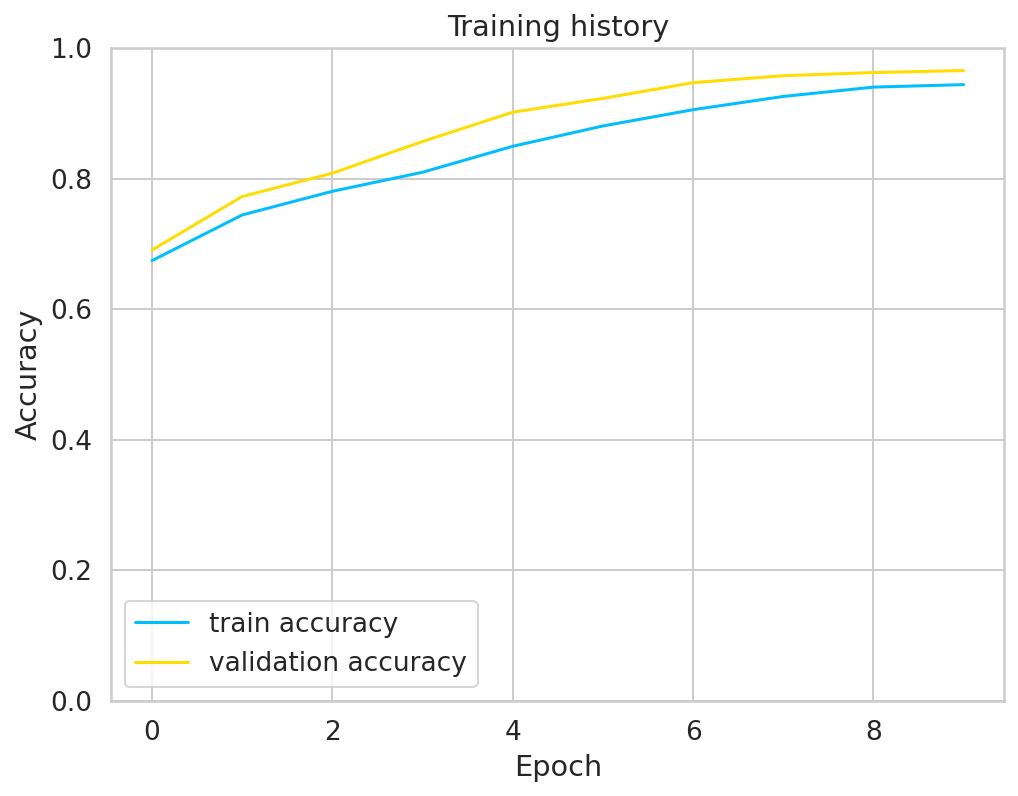

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(project_test)
)

test_acc.item()

In [ ]:
import torch
from torch import nn, optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids, attention_mask=attention_mask

      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, y_pred))